<FONT COLOR="RED" SIZE="6">Hybrid Methods</FONT>
<P><FONT COLOR="yELLOW" SIZE="4">1_BORUTA</FONT>

<font color="pink">#pip install boruta</font>

*Boruta is a feature selection algorithm that identifies all relevant features in a dataset by iteratively training a random forest (or similar ensemble model) and comparing the importance of actual features to randomly generated shadow features.*

In [8]:
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from boruta import BorutaPy
import pandas as pd

In [9]:
# Load the wine dataset
wine = load_wine()
X, y = wine.data, wine.target
feature_names = wine.feature_names

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [10]:
# Initialize Boruta
boruta = BorutaPy(
    estimator=rf,
    n_estimators='auto',
    max_iter=200,  # Increase iterations
    alpha=0.01,    # Stricter threshold for feature inclusion
    random_state=42
)

In [11]:
# Fit Boruta on the training data
boruta.fit(X_train, y_train)


BorutaPy(alpha=0.01,
         estimator=RandomForestClassifier(n_estimators=50,
                                          random_state=RandomState(MT19937) at 0x20768C01D40),
         max_iter=200, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x20768C01D40)

In [12]:
# Retrieve selected features
selected_features = boruta.support_
selected_feature_names = [feature for feature, selected in zip(feature_names, selected_features) if selected]

# Print results
print("Selected Features by Boruta:")
print(selected_feature_names)

Selected Features by Boruta:
['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


In [13]:
# Create a DataFrame with feature rankings
feature_rankings = pd.DataFrame({
    'Feature': feature_names,
    'Rank': boruta.ranking_,
    'Selected': boruta.support_
}).sort_values(by='Rank')

print("\nFeature Rankings:")
print(feature_rankings)



Feature Rankings:
                         Feature  Rank  Selected
0                        alcohol     1      True
1                     malic_acid     1      True
2                            ash     1      True
3              alcalinity_of_ash     1      True
4                      magnesium     1      True
5                  total_phenols     1      True
6                     flavanoids     1      True
7           nonflavanoid_phenols     1      True
8                proanthocyanins     1      True
9                color_intensity     1      True
10                           hue     1      True
11  od280/od315_of_diluted_wines     1      True
12                       proline     1      True


In [14]:
# Evaluate the model using selected features
X_train_selected = boruta.transform(X_train)
X_test_selected = boruta.transform(X_test)

rf.fit(X_train_selected, y_train)
train_accuracy = rf.score(X_train_selected, y_train)
test_accuracy = rf.score(X_test_selected, y_test)

print(f"\nModel Performance with Selected Features:")
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")


Model Performance with Selected Features:
Train Accuracy: 1.00
Test Accuracy: 0.98


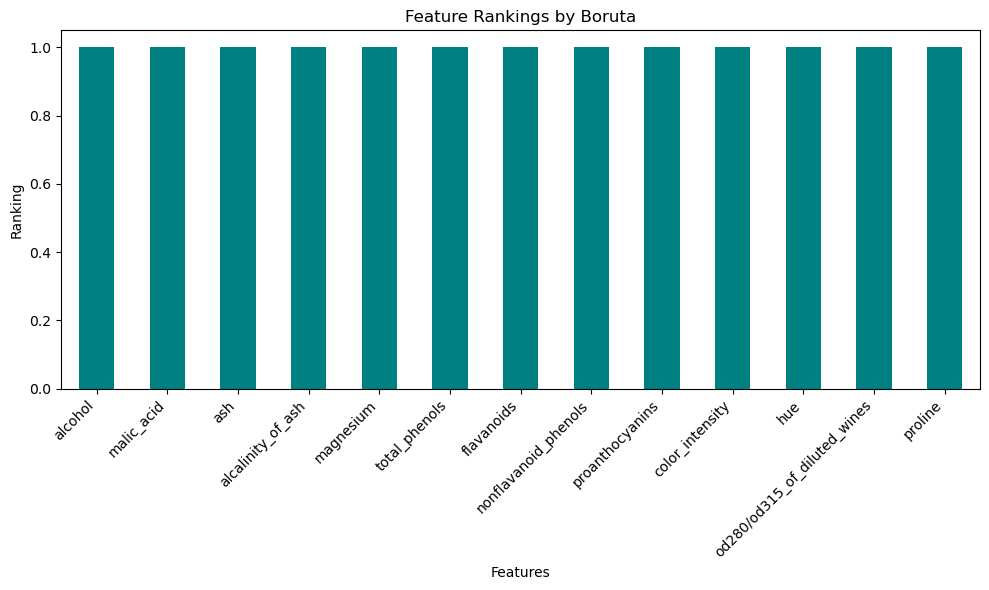

In [16]:
import matplotlib.pyplot as plt
# Plot feature rankings
plt.figure(figsize=(10, 6))
feature_rankings.set_index('Feature')['Rank'].plot(kind='bar', color='teal')
plt.title("Feature Rankings by Boruta")
plt.xlabel("Features")
plt.ylabel("Ranking")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<b><font color='orange'>Advantages of Boruta:</font></b>

<li>Identifies all relevant features without prematurely discarding correlated ones.</li>
    <li>Robust to noise due to shadow feature comparisons.</li>
    <li>Simple to implement with ensemble models.</li>

<b><font color='orange'>Limitations:</font></b>

<li>Computationally expensive for very large datasets.</li>
    <li>Does not directly handle interactions between features.</li>

<b>If the Boruta algorithm selects all the features from the dataset, it may indicate that all features are considered relevant for the target variable in the Wine dataset. This is possible, as the dataset is well-structured and features are carefully chosen to distinguish between wine classes.

However, it is worth verifying whether:

 <li>The dataset genuinely requires all features for optimal performance.</li>
 <li>The Boruta settings need adjustment to identify only the most important features.</li>

<font size=3>CROSS CHECK</font>

In [17]:
# Model with all features
rf_all = RandomForestClassifier(n_estimators=100, random_state=42)
rf_all.fit(X_train, y_train)
train_acc_all = rf_all.score(X_train, y_train)
test_acc_all = rf_all.score(X_test, y_test)

# Model with Boruta-selected features
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train_selected, y_train)
train_acc_selected = rf_selected.score(X_train_selected, y_train)
test_acc_selected = rf_selected.score(X_test_selected, y_test)

print(f"Accuracy with All Features - Train: {train_acc_all:.2f}, Test: {test_acc_all:.2f}")
print(f"Accuracy with Selected Features - Train: {train_acc_selected:.2f}, Test: {test_acc_selected:.2f}")


Accuracy with All Features - Train: 1.00, Test: 1.00
Accuracy with Selected Features - Train: 1.00, Test: 1.00


 <b><font color="orange">Review Shadow Feature Comparison:</font></b>

<li>Shadow features are randomly shuffled copies of original features. If original features consistently outperform shadow features, Boruta will keep them.

You can verify shadow feature importance during Boruta runs.</li>

<b><font color="orange">Adjust Boruta Settings</font>

Boruta’s sensitivity depends on its configuration. You can:

<li><b>Increase max_iter:</b> Allow more iterations for better convergence.</li>
    <li><b>Use stricter criteria:</b>
        Set alpha (default = 0.05) to a smaller value to make the algorithm more stringent in feature selection.</li>

<b>Possible Reasons for Selecting All Features:</b>
<ol>
    <li><font color="yellow">Strong Dataset Design:</font>
        The Wine dataset is a benchmark dataset, and all features may truly be relevant.</li>

   <li><font color="yellow"> High Correlation Between Features:</font>
        Boruta identifies all features contributing directly or indirectly to the target variable.</li>
<li><font color="yellow">Random Forest Tendency:</font>
        Random forests naturally rank all features with some importance, and Boruta inherits this.</li></ol>